# Example Airyscan

Example of flow meausurement with the Airyscan. Sample: 80 nM ATTO488 in a flow chamber under 62.5 mbar. Measurement near the center of the well.

See "Dilissen S., et al., BBA - General Subjects, 2024."

Load packages

In [1]:
from brighteyes_ffs.fcs.fcs2corr import fcs_load_and_corr_split as correlate
from brighteyes_ffs.fcs.fcs2corr import fcs_av_chunks
from brighteyes_ffs.fcs.fcs_fit import fcs_fit
from brighteyes_ffs.fcs.get_fcs_info import get_metafile_from_file, get_file_info
from brighteyes_ffs.fcs.plot_fingerprint import plot_fingerprint_airyscan
from brighteyes_ffs.fcs.plots import plot_timetrace, plot_corrs, plot_corrs_av, plot_corrs_fit, plot_difflaw, plot_flow_heat_map, plot_anisotropy_heat_map
from brighteyes_ffs.fcs.fcs_polar import g2flow
from brighteyes_ffs.fcs.plot_corrs_scheme import plot_correlations_microimage
from brighteyes_ffs.tools.print_tools import print_table
import matplotlib.pyplot as plt
import numpy as np

File name and correlation options to calculate.

list_of_g is a list of correlations to calculate. 'crossAll' is a predefined keyword which will calculate all cross-correlations

averaging is a list of correlations to average, which can be done for correlations between pairs of detector elements with similar relative positions.

list_of_g_out is a list where you can choose the names of the averaged correlations. E.g., 'Angle0' means the average cross-correlation of all pairs with relative shifts in the horizontal direction, only.

In [2]:
file = "D:/atto_airyscan/20231511_M1_ATTO488_80nM_62-5mBar_1485_Z-001_4.h5"
list_of_g = ['crossAll']
list_of_g_out = ['Angle0', 'Angle60', 'Angle120', 'Angle180', 'Angle240', 'Angle300']
averaging = ['0x18+3x6+12x0+2x7+11x1+10x8+4x17+13x5+14x16', '0x16+2x5+10x0+1x17+9x6+8x18+3x15+11x4+12x14', '0x14+1x4+8x0+2x13+9x3+10x12+6x15+7x5+18x16', '0x12+6x3+18x0+17x4+5x13+16x14+7x2+1x11+8x10', '0x10+5x2+16x0+6x9+17x1+18x8+15x3+4x11+14x12', '0x8+4x1+14x0+3x9+13x2+12x10+5x7+15x6+16x18']
algorithm = 'sparse_matrices' #'sparse_matrices' for fast time-domain calculation
resolution = 20 #the higher this number, the more points the correlation will have
chunksize = 0.2 # split the data in segments of this length (in seconds) and calculate the ACF for each segment separately
time_trace = True # return the intensity time trace

In [4]:
mdata = get_file_info(file)

Calculate correlations

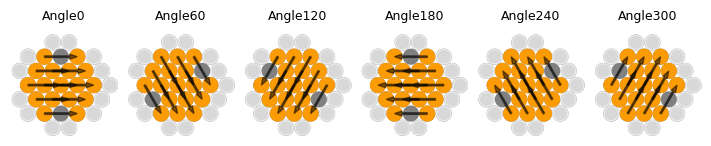

In [6]:
plot_correlations_microimage('airyscan', list_of_g, list_of_g_out, averaging, figsize=(7,7))

In [7]:
G, time_trace = correlate(file, list_of_g=list_of_g, accuracy=resolution, split=chunksize, time_trace=True, averaging=averaging, list_of_g_out=list_of_g_out, algorithm=algorithm)

+--------------------+
| Loading chunk 1/73 |
+--------------------+
(12320768, 32)
     --> crossAll: Calculating all crosscorrelations with sparse matrices algorithm
+--------------------+
| Loading chunk 2/73 |
+--------------------+
(12320768, 32)
     --> crossAll: Calculating all crosscorrelations with sparse matrices algorithm
+--------------------+
| Loading chunk 3/73 |
+--------------------+
(12320768, 32)
     --> crossAll: Calculating all crosscorrelations with sparse matrices algorithm
+--------------------+
| Loading chunk 4/73 |
+--------------------+
(12320768, 32)
     --> crossAll: Calculating all crosscorrelations with sparse matrices algorithm
+--------------------+
| Loading chunk 5/73 |
+--------------------+
(12320768, 32)
     --> crossAll: Calculating all crosscorrelations with sparse matrices algorithm
+--------------------+
| Loading chunk 6/73 |
+--------------------+
(12320768, 32)
     --> crossAll: Calculating all crosscorrelations with sparse matrices al

### Plot time trace

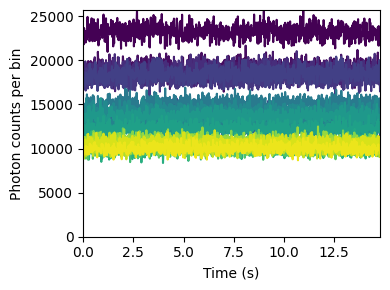

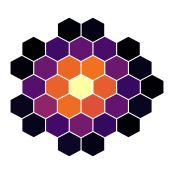

In [10]:
plot_timetrace(time_trace[:-10,:], mdata.duration, figsize=(4,3), cmap='viridis', return_fig=False)

sx, sy, cc = plot_fingerprint_airyscan(np.sum(time_trace, 0), plot=True, figsize=(2,2))

### Plot correlations  

In [11]:
idx = [i for i in range(73)]
G.average_chunks(idx)

findfont: Font family ['DejaVu Sans Display'] not found. Falling back to DejaVu Sans.


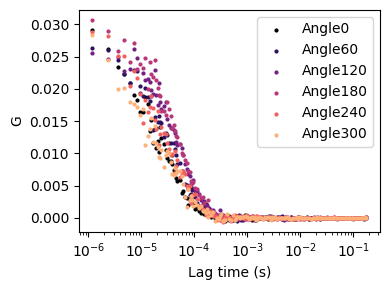

In [12]:
plot_corrs_av(G, figsize=(4,3), cmap='magma', return_fig=False)

The correlations look different for different directions, indicating flow. This can also be visualized with a polar plot.

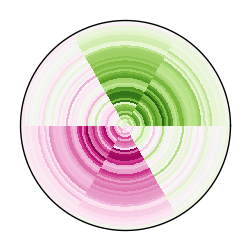

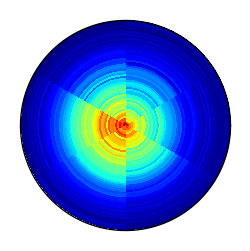

In [13]:
corrs, _, _ = G.get_av_corrs(list_of_g_out, av='_averageX') # make a 2D array with each column 1 of the 4 correlation curves
plot_flow_heat_map(corrs[1:50,:], detector='airy6', cmap='PiYG')
plot_anisotropy_heat_map(corrs[1:60,:], cmap='jet')

### Fit correlations 

To quantify the flow speed, fit the correlations with a global fit.

For fitfun = 'fcs_fit_dualfocus', the order of the 9 parameters for fitting is
* c: emitter concentration [/um^3]
* D: diffusion coefficient [um^2/s]
* w0: beam waist [nm]
* SF: shape factor [dim.less]
* rho_x, rho_y: distance in x,y direction between each pair of detector elements [nm]
* v_x, v_y: flow speed in x,y direction [um/s]
* offset

We fit c, D, w0, v_x, and v_y in a global fit. The parameters rho_x and rho_y are different for each of the 6 curves.

In [14]:
from brighteyes_ffs.fcs.fcs_fit import fcs_fit_dualfocus as my_fit_fun # you chose Free diffusion with flow - global fit as the fit function

In [15]:
# order of parameters:     N      D      w0     SF     rhox   rhoy   vx     vy     offset
fit_info     = np.asarray([True,  True,  False, False, False, False, True,  True,  False])
global_param = np.asarray([True,  True,  False, False, False, False, True,  True,  False])
lbounds      = np.asarray([0,     1e-3,  0.05,  0,     -1e6,  -1e6,  -1e9,  -1e9,  -100.0]) # the lower bounds for the fit parameters
ubounds      = np.asarray([1e6,   1e3,   1e4,   1e6,   1e6,   1e6,   1e9,   1e9,   1e6]) # the upper bounds for the fit parameters

rho_x        = np.asarray([0.0,   103.0, 103.0, 0.0,   -103.0, -103.0]) # horizontal displacement between detector elements (nm)
rho_y        = np.asarray([119.0, 59.0, -59.0, -119.0, -59.0, 59.0]) # vertical displacement between detector elements (nm)

start_idx = 3
stop_idx = 85

param = np.zeros((len(fit_info), len(list_of_g_out)))
G_all = []
for i, corr in enumerate(list_of_g_out):
    param[:, i] = np.asarray([1, 250, 206, 5.0, rho_x[i], rho_y[i], 0, 0, 0]) # order of parameters: N, D, w0, SF, rhox, rhoy, vx, vy, offset
    G_all.append(getattr(G, corr+'_averageX')[:,1])
    tau = getattr(G, corr+'_averageX')[:,0]
G_all = np.transpose(np.asarray(G_all))

In [16]:
fitresult = fcs_fit(G_all[start_idx:stop_idx,:], tau[start_idx:stop_idx], my_fit_fun, fit_info, param, lbounds, ubounds, plotInfo=-1, global_param=global_param)

In [17]:
from brighteyes_ffs.tools.color_from_map import color_from_map

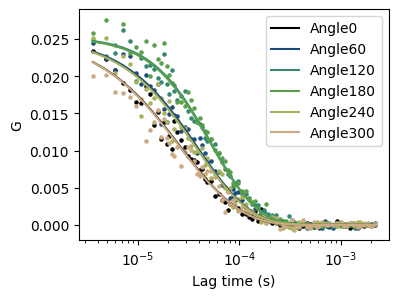

In [19]:
plt.figure(figsize=(4,3))
for f, corr in enumerate(list_of_g_out):
    color = color_from_map(np.mod(f, len(list_of_g_out)), startv=0, stopv=len(list_of_g_out), cmap='gist_earth')
    Gsingle = getattr(G, corr + '_averageX')
    plt.scatter(tau[start_idx:stop_idx], G_all[start_idx:stop_idx,f], s=5, color=color)
    plt.plot(tau[start_idx:stop_idx], G_all[start_idx:stop_idx,f]-fitresult.fun[:,f], label=corr, color=color)
plt.xscale('log')
plt.xlabel('Lag time (s)')
plt.ylabel('G')
plt.legend()

In [20]:
fitted_speed = np.sqrt(fitresult.x[6,0]**2 + fitresult.x[7,0]**2)
print(f"fitted speed: {fitted_speed:.1f} um/s")

fitted speed: 3868.1 um/s


The following table gives the parameter values for all (both fitted and fixed) parameters.

In [24]:
print_table(fitresult.x)

         curve 1 curve 2 curve 3 curve 4 curve 5 curve 6
 param 1   28.30   28.30   28.30   28.30   28.30   28.30
 param 2  360.31  360.31  360.31  360.31  360.31  360.31
 param 3  206.00  206.00  206.00  206.00  206.00  206.00
 param 4    5.00    5.00    5.00    5.00    5.00    5.00
 param 5    0.00  103.00  103.00    0.00 -103.00 -103.00
 param 6  119.00   59.00  -59.00 -119.00  -59.00   59.00
 param 7 2055.62 2055.62 2055.62 2055.62 2055.62 2055.62
 param 8-3276.70-3276.70-3276.70-3276.70-3276.70-3276.70
 param 9    0.00    0.00    0.00    0.00    0.00    0.00
